# Seizure detection sandbox

## Workspace Preparation

In [1]:
# Scientific computing imports
import numpy as np
import scipy as sc
import pandas as pd
import json
from scipy.linalg import hankel
from tqdm import tqdm
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import minmax_scale

# Data IO imports
import mne
import mne_bids
from mne_bids import BIDSPath, read_raw_bids

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Imports for deep learning
import random
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset

# OS imports
import os
from os.path import join as ospj
from os.path import exists as ospe
from utils import *
import sys
from seizure_detection_pipeline import *
sys.path.append('/users/wojemann/iEEG_processing')
plt.rcParams['image.cmap'] = 'magma'

2024-08-19 11:28:02.548574: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-19 11:28:04.021065: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
_,_,datapath,prodatapath,metapath,figpath,patient_table,rid_hup,_ = load_config(ospj('/mnt/leif/littlab/users/wojemann/stim-seizures/code','config.json'))

In [3]:
set_seed(5210)

In [24]:
seizures_df = pd.read_csv(ospj(metapath,"stim_seizure_information_BIDS.csv"))
pt = 'HUP253'
montage = 'bipolar'

## Anomaly Detection

### Generating model predictions

In [25]:
def preprocess_for_detection(data,fs,montage='bipolar',target=256, wavenet=False, pre_mask = None):
    # This function implements preprocessing steps for seizure detection
    chs = data.columns.to_list()
    ch_df = check_channel_types(chs)
    # Montage
    if montage == 'bipolar':
        data_bp_np,bp_ch_df = bipolar_montage(data.to_numpy().T,ch_df)
        bp_ch = bp_ch_df.name.to_numpy()
    elif montage == 'car':
        data_bp_np = (data.to_numpy().T - np.mean(data.to_numpy(),1))
        bp_ch = chs
    
    # Channel rejection
    if pre_mask is None:
        mask,_ = detect_bad_channels(data_bp_np.T*1e3,fs)
        data_bp_np = data_bp_np[mask,:]
        bp_ch = bp_ch[mask]
    else:
        data_bp_np = data_bp_np[pre_mask,:]
        bp_ch = bp_ch[pre_mask]
    
    if wavenet:
        target=128
        data_bp_notch = notch_filter(data_bp_np,fs)
        data_bp_filt = bandpass_filter(data_bp_notch,fs,lo=3,hi=127)
        signal_len = int(data_bp_filt.shape[1]/fs*target)
        data_bpd = sc.signal.resample(data_bp_filt,signal_len,axis=1).T
        fsd = int(target)
    else:
        # Bandpass filtering
        # b,a = sc.signal.butter(4,[3,40],btype='bandpass',fs = fs)
        # data_bp_filt = sc.signal.filtfilt(b,a,data_bp_np,axis=1)
        data_bp_notch = notch_filter(data_bp_np,fs)
        data_bp_filt = bandpass_filter(data_bp_notch,fs,lo=3,hi=100)
        # Down sampling
        signal_len = int(data_bp_filt.shape[1]/fs*target)
        data_bpd = sc.signal.resample(data_bp_filt,signal_len,axis=1).T
        fsd = int(target)
    data_white = ar_one(data_bpd)
    data_white_df = pd.DataFrame(data_white,columns = bp_ch)
    if pre_mask is None:
        return data_white_df,fsd,mask
    else:
        return data_white_df,fsd

(<Figure size 333.268x2200 with 1 Axes>, <Axes: xlabel='Time (s)'>)

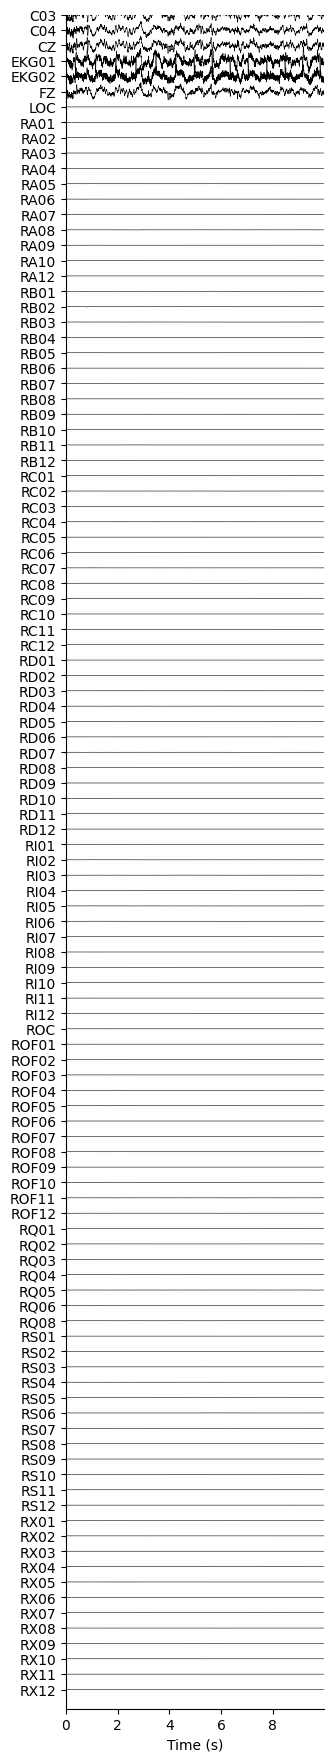

In [26]:
# Loading data from bids
inter,fs_raw = get_data_from_bids(ospj(datapath,"BIDS"),pt,'interictal')
plot_iEEG_data(inter,np.arange(len(inter))/fs_raw)

In [27]:
def remove_scalp_electrodes(raw_labels):
    scalp_list = ['CZ','FZ','PZ',
                  'A01','A02',
                  'C03','C04',
                  'F03','F04','F07','F08',
                  'Fp01','Fp02',
                  'O01','O02',
                  'P03','P04',
                  'T03','T04','T05','T06',
                  'EKG01','EKG02',
                  'ROC','LOC',
                  'EMG01','EMG02',
                  'DC01','DC07'
                  ]
    chop_scalp = ['C1'+str(x) for x in range(19,29)]
    scalp_list += chop_scalp
    return [l for l in raw_labels if l.upper() not in scalp_list]

In [28]:
# Pruning channels
chn_labels = remove_scalp_electrodes(inter.columns)
inter = inter[chn_labels]
# plot_iEEG_data(inter,np.arange(len(inter))/fs_raw)

In [29]:
try:
    electrode_localizations,electrode_regions = electrode_wrapper(pt,rid_hup,datapath)
    electrode_localizations.name = clean_labels(electrode_localizations.name,pt)
    electrode_regions.name = clean_labels(electrode_regions.name,pt)
    electrode_localizations.to_pickle(ospj(prodatapath,pt,'electrode_localizations_atropos.pkl'))
    electrode_regions.to_pickle(ospj(prodatapath,pt,'electrode_localizations_dkt.pkl'))
    neural_channels = electrode_localizations.name[(electrode_localizations.name.isin(inter.columns)) & ((electrode_localizations.label == 'white matter') | (electrode_localizations.label == 'gray matter'))]
except:
    print(f"electrode localization failed for {pt}")
    neural_channels = chn_labels
inter_neural = inter.loc[:,neural_channels]
# plot_iEEG_data(inter_neural,np.arange(len(inter_neural))/fs_raw)

In [30]:
inter,fs,mask = preprocess_for_detection(inter_neural,fs_raw,wavenet=False,target=128)

In [31]:
# plot_iEEG_data(inter,np.arange(len(inter))/fs)

In [32]:
class NRG():
    def __init__(self, win_size = 1, stride = 0.5, fs = 256):
        self.win_size = win_size
        self.stride = stride
        self.fs = fs
        self.function = lambda x: np.sum(sig.welch(x,self.fs)[1],axis=-1)

    
    def __str__(self) -> str:
        return "NRG"
        
    def fit(self, x):
        # x should be samples x channels df
        self.scaler = RobustScaler().fit(x)
        self.inter = pd.DataFrame(self.scaler.transform(x),columns=x.columns)
        self.nstds = np.std(self.inter,axis=0)

    def get_times(self, x):
        # x should be samples x channels df
        time_mat = MovingWinClips(np.arange(len(x))/self.fs,self.fs,self.win_size,self.stride)
        return time_mat[:,-1]

    def forward(self, x):
        # x is samples x channels df
        self.data = x
        x = self.scaler.transform(x)
        x = x.T
        nrg = ft_extract(x, self.fs, self.function, self.win_size, self.stride)
        nrg = nrg.squeeze()
        # normalized_nrg = scale_normalized(nrg)
        # return normalized_nrg
        return nrg/10
    
    def __call__(self, *args):
        return self.forward(*args)

In [33]:
model = NRG(1,.5,128)
model.fit(inter)

In [34]:
# plot_iEEG_data(model.inter,np.arange(len(model.inter))/fs)

In [35]:
seizure_times = seizures_df[seizures_df.Patient == pt]
qbar = tqdm(seizure_times.iterrows(),total=len(seizure_times),leave=False)
for i,(_,sz_row) in enumerate(qbar):
    set_seed(1071999)
    if i <=6:
        continue
    # Load in seizure and metadata for BIDS path
    seizure_raw,fs_raw, _, _, task, run = get_data_from_bids(ospj(datapath,"BIDS"),pt,str(int(sz_row.approximate_onset)),return_path=True, verbose=0)
    break

In [48]:
task

'ictal272901'

In [36]:
# plot_iEEG_data(seizure_raw,np.arange(len(seizure_raw))/fs_raw)

In [37]:
# Filter out bad channels from interictal clip
seizure_neural = seizure_raw[neural_channels]
# plot_iEEG_data(seizure_neural,np.arange(len(seizure_neural))/fs_raw)

In [38]:
seizure_prep,fs,_ = preprocess_for_detection(seizure_neural,fs_raw,
                                                wavenet=False,
                                                # pre_mask=mask,
                                                target=128)

In [39]:
seizure_prep.shape

(19455, 56)

In [40]:
# plot_iEEG_data(seizure_prep,np.arange(len(seizure_prep))/fs)
seizure_prep.max()

RA02-RA03    0.459482
RA03-RA04    0.196946
RA04-RA05    0.143054
RA05-RA06    0.069717
RA06-RA07    0.084940
RA07-RA08    0.226658
RA08-RA09    0.119980
RA09-RA10    0.075012
RB01-RB02    1.697808
RB02-RB03    1.620879
RB03-RB04    0.639347
RB04-RB05    0.183754
RB05-RB06    0.070464
RB08-RB09    0.178425
RB09-RB10    0.052743
RC01-RC02    1.651566
RC02-RC03    0.743698
RC03-RC04    0.088180
RC04-RC05    0.044990
RC05-RC06    0.046384
RC08-RC09    0.060612
RD01-RD02    0.168159
RD02-RD03    0.121007
RD03-RD04    0.113958
RD04-RD05    0.079053
RD05-RD06    0.155732
RD06-RD07    0.180921
RD07-RD08    0.220284
RI02-RI03    0.335366
RI03-RI04    0.329570
RI04-RI05    0.352499
RI05-RI06    0.168426
RI06-RI07    0.273035
RI07-RI08    0.084801
RQ02-RQ03    0.236507
RQ03-RQ04    0.172469
RQ04-RQ05    0.136540
RQ05-RQ06    0.224870
RS01-RS02    0.083176
RS02-RS03    0.097440
RS03-RS04    0.099448
RS04-RS05    0.060147
RS05-RS06    0.119669
RS06-RS07    0.161592
RS07-RS08    0.142391
RS08-RS09 

(<Figure size 5066.15x1120 with 1 Axes>, <Axes: xlabel='Time (s)'>)

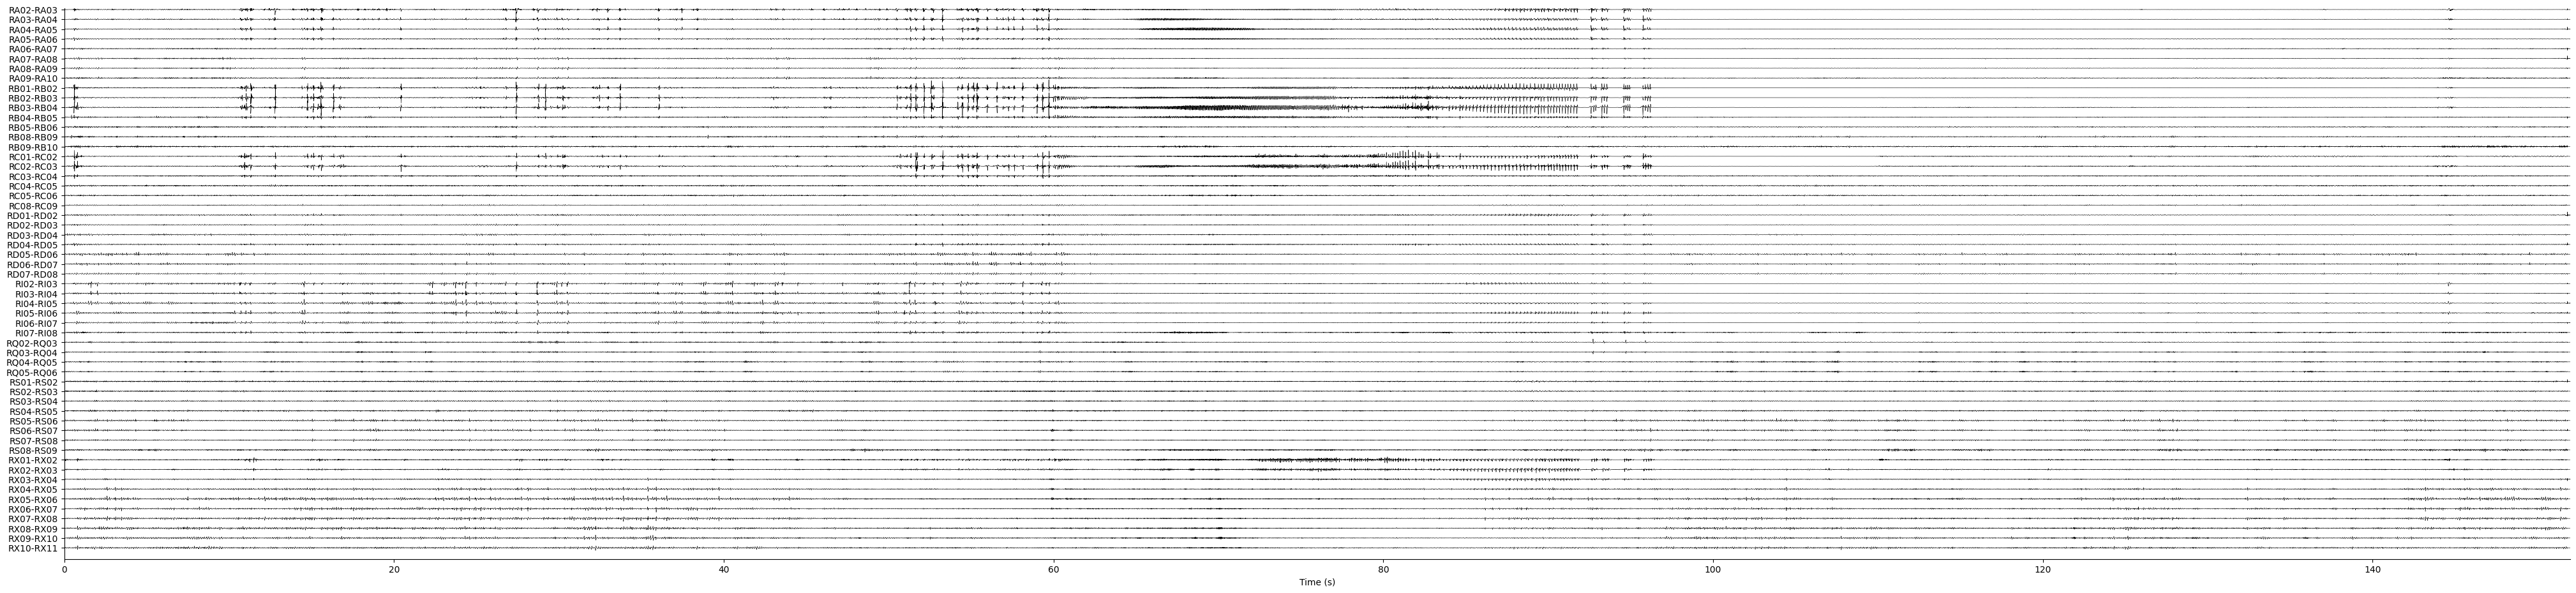

In [41]:
plot_iEEG_data(pd.DataFrame(model.scaler.transform(seizure_prep),columns=seizure_prep.columns),
np.arange(len(seizure_prep))/fs)

In [42]:
preds = model(seizure_prep)
preds_smooth = sc.ndimage.uniform_filter1d(preds,20,axis=1)

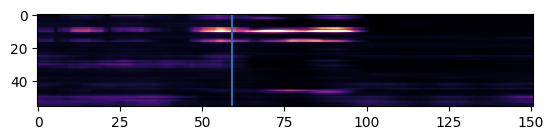

In [43]:
plt.imshow(preds_smooth)
plt.clim([0,1])
tiks = np.arange(0,preds_smooth.shape[1],50)
times = model.get_times(seizure_prep)
plt.xticks(tiks,times[tiks].astype(int))
plt.axvline(np.argmin(np.abs(times-60)))

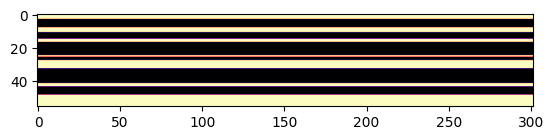

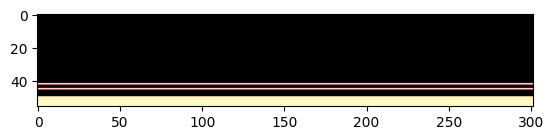

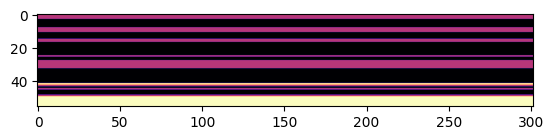

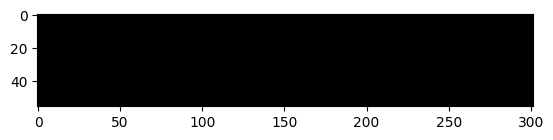

In [44]:
ch_mask_early = np.zeros_like(preds_smooth)
ch_mask_late = np.zeros_like(preds_smooth)
ch_mask_all = np.zeros_like(preds_smooth)
early = np.sum(preds_smooth[:,:118] > .1,axis=1) > 30
late = np.sum(preds_smooth[:,-118:] > .1,axis=1) > 30
all_mask = np.sum(preds_smooth > 0.75,axis=1) > preds_smooth.shape[1]/2
ch_mask_early[early,:] = 1
ch_mask_late[late,:] = 1
ch_mask_all[all_mask,:] = 1
plt.imshow(ch_mask_early)
plt.figure()
plt.imshow(ch_mask_late)
plt.figure()
plt.imshow(ch_mask_early + ch_mask_late)
plt.figure()
plt.imshow(ch_mask_all)

In [45]:
print(seizure_prep.columns[early])
print(seizure_prep.columns[late])

Index(['RA02-RA03', 'RA03-RA04', 'RA04-RA05', 'RB01-RB02', 'RB02-RB03',
       'RB03-RB04', 'RC01-RC02', 'RC02-RC03', 'RD05-RD06', 'RI02-RI03',
       'RI03-RI04', 'RI04-RI05', 'RI05-RI06', 'RI06-RI07', 'RS05-RS06',
       'RS06-RS07', 'RX04-RX05', 'RX05-RX06', 'RX06-RX07', 'RX07-RX08',
       'RX08-RX09', 'RX09-RX10', 'RX10-RX11'],
      dtype='object')
Index(['RS05-RS06', 'RS08-RS09', 'RX05-RX06', 'RX06-RX07', 'RX07-RX08',
       'RX08-RX09', 'RX09-RX10', 'RX10-RX11'],
      dtype='object')


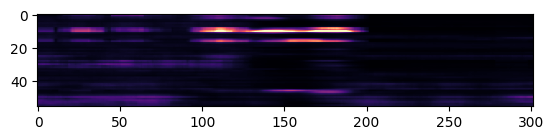

In [46]:
preds_smooth_reject = preds_smooth[~late,:]
plt.imshow(preds_smooth)
plt.clim(0,1)

In [47]:
onset_chs_list = []
for t in np.arange(0,.5,.01):
    late = np.sum(preds_smooth[:,-118:] > t,axis=1) > 30
    preds_smooth_reject = preds_smooth[~late,:]
    print(preds_smooth_reject.shape)
    onset_ch_idxs = np.all(preds_smooth_reject[:,118:123]>t,axis=1)
    sz_chs = seizure_prep.columns[~late]
    onset_chs = sz_chs[onset_ch_idxs]
    onset_chs_list.append(onset_chs)
print('check')

(0, 302)
(6, 302)
(15, 302)
(26, 302)
(32, 302)
(43, 302)
(44, 302)
(45, 302)
(47, 302)
(48, 302)
(48, 302)
(53, 302)
(53, 302)
(53, 302)
(54, 302)
(56, 302)
(56, 302)
(56, 302)
(56, 302)
(56, 302)
(56, 302)
(56, 302)
(56, 302)
(56, 302)
(56, 302)
(56, 302)
(56, 302)
(56, 302)
(56, 302)
(56, 302)
(56, 302)
(56, 302)
(56, 302)
(56, 302)
(56, 302)
(56, 302)
(56, 302)
(56, 302)
(56, 302)
(56, 302)
(56, 302)
(56, 302)
(56, 302)
(56, 302)
(56, 302)
(56, 302)
(56, 302)
(56, 302)
(56, 302)
(56, 302)
check


In [ ]:
onset_chs_list

## Not ready

[Index([], dtype='object'),
 Index([], dtype='object'),
 Index([], dtype='object'),
 Index(['LB08-LB09', 'LB10-LB11'], dtype='object'),
 Index(['LA06-LA07', 'LA07-LA08', 'LB10-LB11'], dtype='object'),
 Index(['LA07-LA08', 'LB06-LB07', 'LB09-LB10', 'LS01-LS02', 'LS04-LS05'], dtype='object'),
 Index(['LA03-LA04', 'LB05-LB06', 'LC03-LC04', 'LC04-LC05', 'LS01-LS02',
        'LS04-LS05'],
       dtype='object'),
 Index(['LA03-LA04', 'LB02-LB03', 'LB05-LB06', 'LC02-LC03', 'LC03-LC04',
        'LC04-LC05', 'LS03-LS04', 'LS04-LS05', 'LS05-LS06'],
       dtype='object'),
 Index(['LB05-LB06', 'LC02-LC03', 'LC03-LC04', 'LS03-LS04', 'LS04-LS05',
        'LS05-LS06', 'LZ01-LZ02', 'LZ07-LZ08'],
       dtype='object'),
 Index(['LB01-LB02', 'LB05-LB06', 'LC02-LC03', 'LC06-LC07', 'LC08-LC09',
        'LQ06-LQ07', 'LS02-LS03', 'LS03-LS04', 'LS04-LS05', 'LY01-LY02',
        'LZ01-LZ02', 'LZ05-LZ06', 'LZ07-LZ08', 'LZ10-LZ11'],
       dtype='object'),
 Index(['LA02-LA03', 'LB04-LB05', 'LC02-LC03', 'LC06-LC

In [26]:
def mad(data):
    # Computes median absolute deviation
    med = np.median(data)
    deviations = np.abs(data-med.reshape(-1,1))
    return np.median(deviations,axis=1)
    

In [27]:
# plot_iEEG_data(seizure_neural,np.arange(len(seizure_neural))/fs)
plot_iEEG_data(seizure,np.arange(len(seizure))/fs)

NameError: name 'seizure' is not defined

Index(['RB02', 'RB08', 'RC02'], dtype='object')


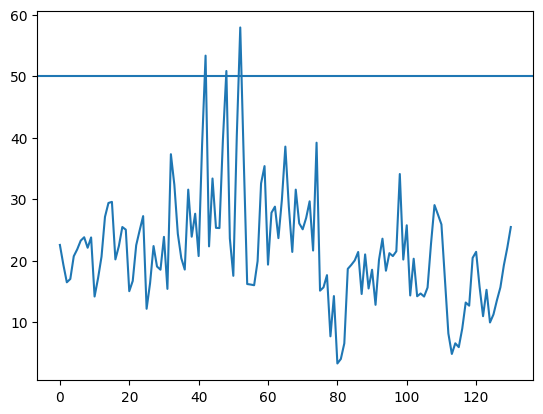

In [ ]:
inter_notch = notch_filter(inter_neural.T,fs_raw)
# deviance = mad(seizure_notch[:,:10*fs_raw]*1e3)
deviance = mad(inter_notch*1e3)

plt.plot(deviance)
plt.axhline(50)
print(inter_neural.columns[deviance > 50])

In [ ]:
a,b = detect_bad_channels(seizure_neural.to_numpy()[:,:30*fs_raw],fs_raw)

In [ ]:
seizure_neural.columns[~a]

Index(['LB02', 'RO06', 'RO08'], dtype='object')

In [ ]:
from scipy.ndimage import uniform_filter1d
def moving_variance(x, window_size):
    # Step 1: Calculate the moving average (mean)
    mean = uniform_filter1d(x, size=window_size, mode='constant',axis=1)
    
    # Step 2: Calculate the moving average of the squared values
    mean_of_squares = uniform_filter1d(x**2, size=window_size, mode='constant',axis=1)
    
    # Step 3: Compute the moving variance
    variance = mean_of_squares - mean**2
    
    return variance

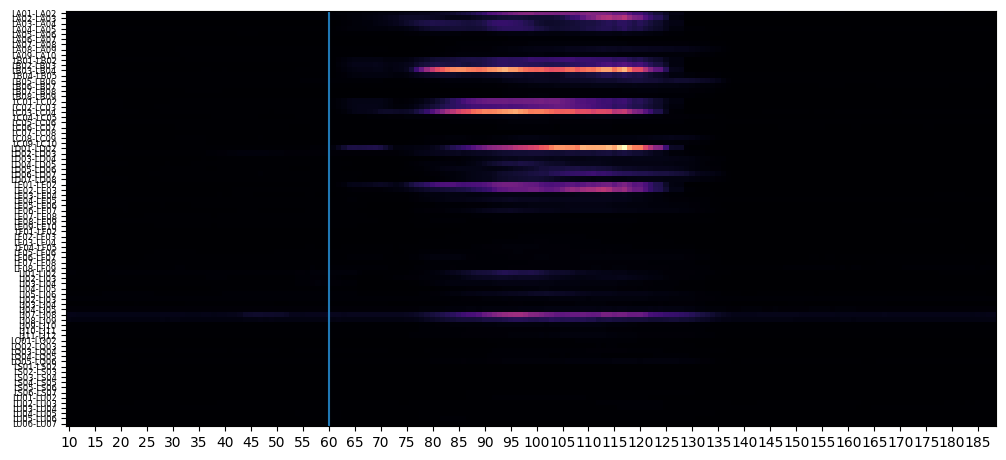

In [ ]:
mdl_outs = model(seizure)
# sz_probs = sc.ndimage.uniform_filter1d(mdl_outs,20,axis=1,mode='constant')
sz_probs = mdl_outs
time_wins = model.get_times(seizure)
plt.figure(figsize=(12,12))
plt.imshow(minmax_scale(sz_probs.reshape(-1,1)).reshape(mdl_outs.shape))
plt.axvline(np.argwhere(np.ceil(time_wins)==60))
plt.xticks(np.arange(0,len(time_wins),5),np.ceil(time_wins[np.arange(0,len(time_wins),5)]).astype(int))
plt.yticks(np.arange(len(seizure.columns)),seizure.columns,fontsize=6);
plt.clim((0,1))
# plt.figure()
# plt.imshow(mdl_outs)

In [ ]:
time_wins

array([ 19.9921875,  20.9921875,  21.9921875,  22.9921875,  23.9921875,
        24.9921875,  25.9921875,  26.9921875,  27.9921875,  28.9921875,
        29.9921875,  30.9921875,  31.9921875,  32.9921875,  33.9921875,
        34.9921875,  35.9921875,  36.9921875,  37.9921875,  38.9921875,
        39.9921875,  40.9921875,  41.9921875,  42.9921875,  43.9921875,
        44.9921875,  45.9921875,  46.9921875,  47.9921875,  48.9921875,
        49.9921875,  50.9921875,  51.9921875,  52.9921875,  53.9921875,
        54.9921875,  55.9921875,  56.9921875,  57.9921875,  58.9921875,
        59.9921875,  60.9921875,  61.9921875,  62.9921875,  63.9921875,
        64.9921875,  65.9921875,  66.9921875,  67.9921875,  68.9921875,
        69.9921875,  70.9921875,  71.9921875,  72.9921875,  73.9921875,
        74.9921875,  75.9921875,  76.9921875,  77.9921875,  78.9921875,
        79.9921875,  80.9921875,  81.9921875,  82.9921875,  83.9921875,
        84.9921875,  85.9921875,  86.9921875,  87.9921875,  88.9

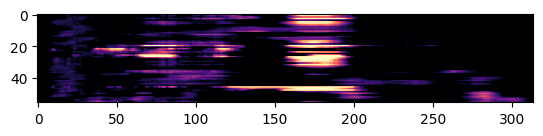

In [ ]:
baseline_mask = sz_probs[:,time_wins <= 20]
scaler = RobustScaler()
scaler.fit(baseline_mask.T)
scale_sz_probs = scale_normalized(scaler.transform(sz_probs.T).T)
plt.imshow(scale_normalized(scale_sz_probs))
plt.clim([0,1])

31


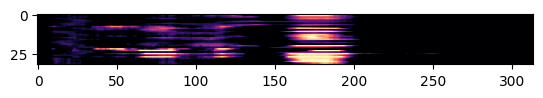

In [ ]:
first_sz_idx_offset = 120
sliced_data = sz_probs[:,first_sz_idx_offset:] > 0.7
first_sz_idxs = np.argmax(sliced_data,axis=1)
seized_idxs = np.any(sliced_data,axis=1)
first_sz_idxs += first_sz_idx_offset
sz_times_arr = time_wins[first_sz_idxs[seized_idxs]]
sz_ch_arr = seizure.columns[seized_idxs]
sz_order = np.argsort(sz_times_arr)
to_zero = (sz_times_arr == np.max(sz_times_arr))
viz_sz_probs = scale_sz_probs.copy()
# viz_sz_probs[to_zero,:] = 0
plt.imshow(viz_sz_probs[sz_order,:])
# plt.imshow(vmat[sz_order,:])
plt.clim([0,1])
print(len(sz_ch_arr[~to_zero]))

In [ ]:
print(sz_ch_arr[sz_order])

Index(['RB04-RB05', 'RA03-RA04', 'RA04-RA05', 'RB01-RB02', 'RB02-RB03',
       'RB03-RB04', 'RC02-RC03', 'RC01-RC02', 'RX01-RX02', 'RX02-RX03',
       'RX03-RX04', 'RA08-RA09', 'RI04-RI05', 'RI02-RI03', 'RI06-RI07',
       'RI03-RI04', 'RA02-RA03', 'RA07-RA08', 'RD01-RD02', 'RC03-RC04',
       'RA05-RA06', 'RD04-RD05', 'RI07-RI08', 'RX04-RX05', 'RD07-RD08',
       'RI05-RI06', 'RA09-RA10', 'RX05-RX06', 'RX08-RX09', 'RX07-RX08',
       'RX06-RX07', 'RX09-RX10'],
      dtype='object')


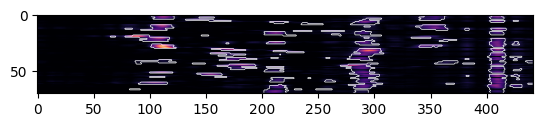

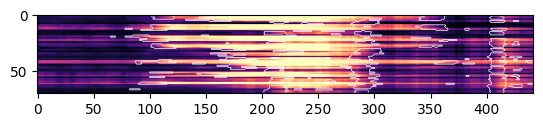

In [ ]:
fig, ax = plt.subplots()
temp = moving_variance(sz_probs,20)[:,30:-30]
threshold = np.mean(temp,axis=1) + np.std(temp,axis=1)
mask = temp > threshold.reshape(-1,1)
ax.imshow(temp)
ax.contour(mask, levels=[0.5], colors='white', linewidths=.5)

fig, ax = plt.subplots()
ax.imshow(sz_probs[:,30:-30])
ax.contour(mask, levels=[0.5], colors='white', linewidths=.5)

#### LSTM

In [ ]:
mdl_str = 'LSTM'
input_size = inter.shape[1]
hidden_size = 10

# Check for cuda
ccheck = torch.cuda.is_available()
# ccheck = False

# Initialize the model
if mdl_str == 'LSTM':
    model = LSTMModel(input_size, hidden_size)
elif mdl_str == 'LSTMX':
    model = LSTMX(input_size,hidden_size)
if ccheck:
    model.cuda()

# Scale the training data
model.fit_scaler(inter)
inter_z = model.scaler_transform(inter)
inter = pd.DataFrame(inter_z,columns=inter.columns)

# Prepare input and target data for the LSTM
input_data,target_data = prepare_segment(inter,fs=128)

dataset = TensorDataset(input_data, target_data)
full_batch = len(dataset)
dataloader = DataLoader(dataset, batch_size=full_batch, shuffle=False)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the model, this will just modify the model object, no returns
# print("Training patient specific model")
train_model(model,dataloader,criterion,optimizer,ccheck=ccheck)

# Creating classification thresholds
input_data,target_data = prepare_segment(inter,fs=128)
inter_outputs = predict_sz(model,input_data,target_data,batch_size=full_batch,ccheck=ccheck)

In [ ]:
inter_mat = repair_data(inter_outputs,inter,fs=128)
inter_mat = np.mean(np.log(inter_mat),1).T
scaler = RobustScaler()
scaler.fit(inter_mat.T)

RobustScaler()

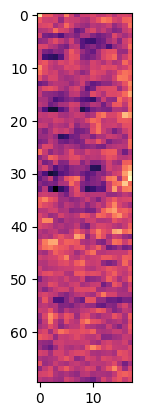

In [ ]:
plt.imshow(inter_mat)

In [ ]:
seizure_z = model.scaler_transform(seizure)
seizure = pd.DataFrame(seizure_z,columns=seizure.columns)
train_win,pred_win=12,1
input_data, target_data,time_wins = prepare_segment(seizure,fs,train_win,pred_win,ret_time=True)
# Generate seizure detection predictions for each window
outputs = predict_sz(model,input_data,target_data,batch_size=len(input_data)//2,ccheck=ccheck)
seizure_mat = repair_data(outputs,seizure,fs=128)
# Getting raw predicted loss values for each window
raw_sz_vals = np.mean(np.log(seizure_mat),1).T
# Creating classifications
# mdl_outs = (raw_sz_vals.T > np.log(thresholds)).T.astype(float)

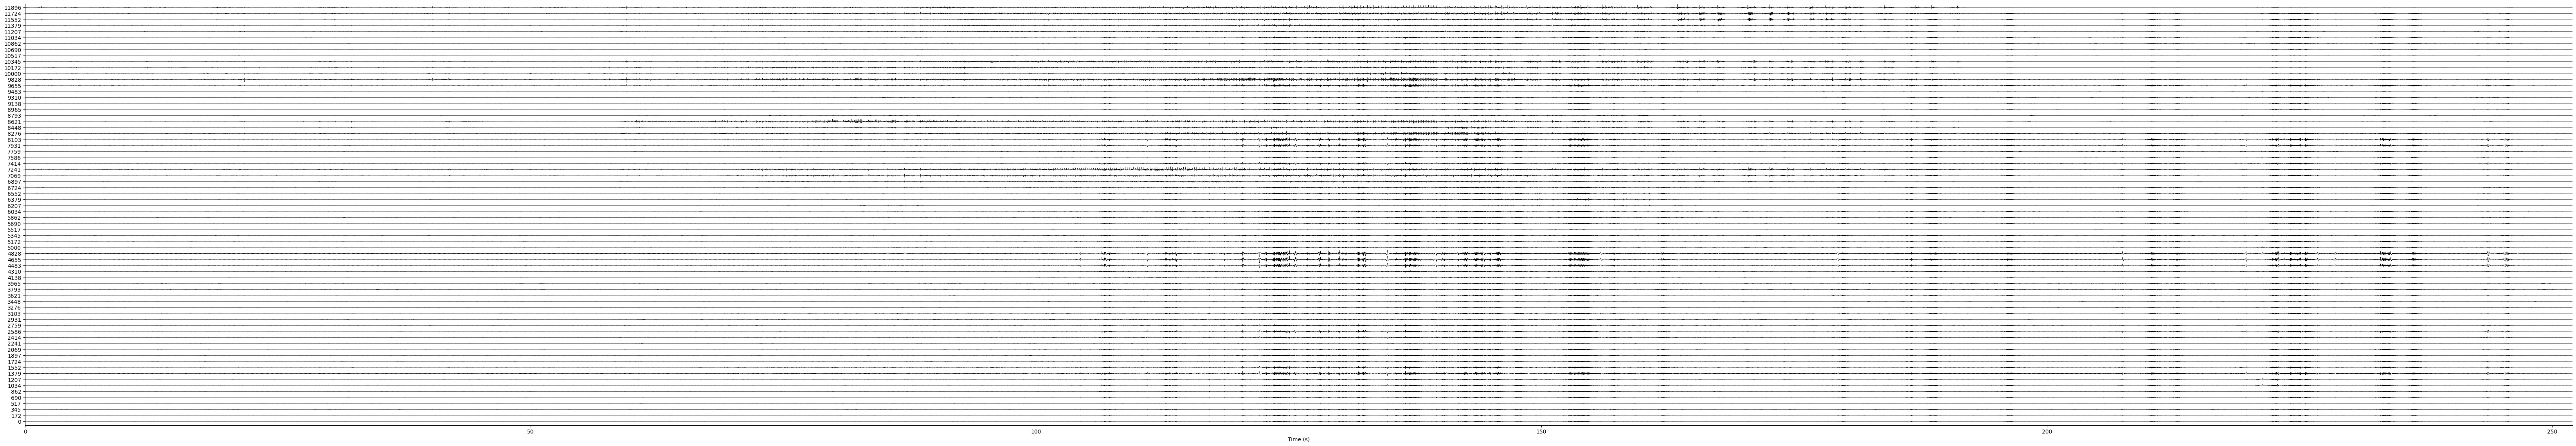

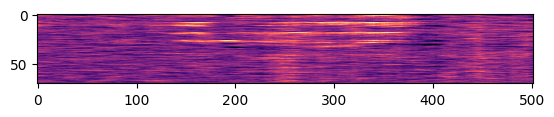

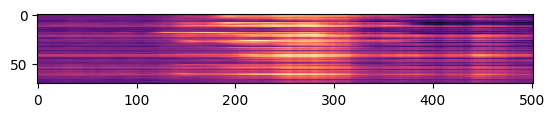

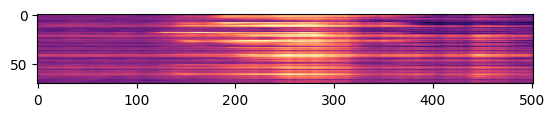

In [ ]:
sz_vars = scale_normalized(np.std(np.log(seizure_mat),1).T)
sz_vals = scale_normalized(raw_sz_vals)
plot_iEEG_data(seizure_z,np.arange(len(seizure_z))/128)
plt.figure()
plt.imshow(sz_vars)
plt.imshow(sc.ndimage.uniform_filter1d(sz_vars,20,axis=1))
# plt.clim([0,1])
plt.figure()
plt.imshow(sc.ndimage.uniform_filter1d(raw_sz_vals,20,axis=1))
# plt.clim([0,1])
plt.figure()
plt.imshow(sc.ndimage.uniform_filter1d(sz_vals*sz_vars,20,axis=1))
# plt.clim([0,1])

In [ ]:
# sz_probs = sc.ndimage.uniform_filter1d(raw_sz_vals,20,axis=1,mode='constant')
# # prob_times = model.get_times(seizure)
# plt.figure(figsize=(12,8))
# plt.imshow(sz_probs)
# xtick_idxs = np.arange(0,len(time_wins),10)
# plt.xlabel('Time (s)')
# plt.title('Seizure Detection Probability')
# l = plt.xticks(xtick_idxs,time_wins[xtick_idxs].astype(int))
# l = plt.yticks([])

### Variance detector

(array([14977.,  3869.,  3488.,  3011.,  2162.,  1589.,   981.,   576.,
          213.,    74.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

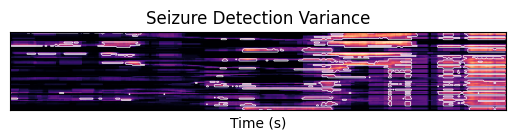

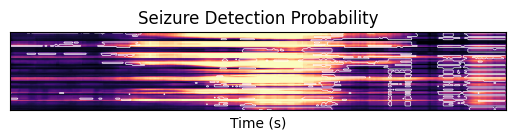

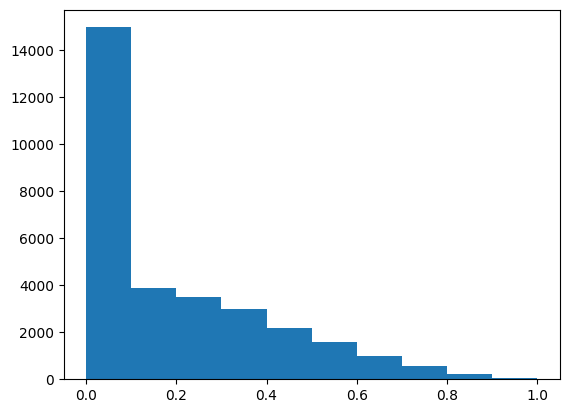

In [ ]:
fig, ax = plt.subplots()
temp = moving_variance(mdl_outs,20)[:,30:-30]
temp_wins = time_wins[-30:30]
threshold = np.mean(temp) + np.std(temp)
mask = temp > threshold
ax.imshow(temp)
ax.contour(mask, levels=[0.5], colors='white', linewidths=.5)
xtick_idxs = np.arange(0,len(temp_wins),10)
plt.xlabel('Time (s)')
plt.title('Seizure Detection Variance')
l = ax.set_xticks(xtick_idxs,temp_wins[xtick_idxs].astype(int))
l = plt.yticks([])

fig, ax = plt.subplots()
ax.imshow(sz_probs[:,30:-30])
ax.contour(mask, levels=[0.5], colors='white', linewidths=.5)
xtick_idxs = np.arange(0,len(temp_wins),10)
plt.xlabel('Time (s)')
plt.title('Seizure Detection Probability')
l = ax.set_xticks(xtick_idxs,temp_wins[xtick_idxs].astype(int))
l = plt.yticks([])

plt.figure()
plt.hist(minmax_scale(temp.flatten()))

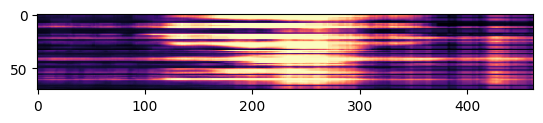

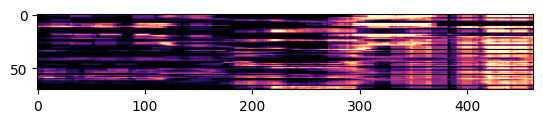

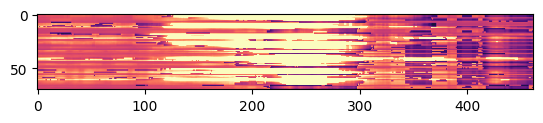

In [ ]:
thresh = 0.75
alpha = 0.2
vars = scale_normalized(moving_variance(mdl_outs,20)[:,20:-20])
# print(vars.shape)
mask = vars > (np.mean(vars,1) + 0.5*np.std(vars,1)).reshape(-1,1)
modifier = (~mask)*0.5
# vmat = scale_normalized(sz_probs[:,20:-20]) * ((1-alpha) + alpha*minmax_scale(vars,(0.8,1),axis=1))
vmat = scale_normalized(sz_probs[:,20:-20]) + modifier
plt.imshow(scale_normalized(sz_probs[:,20:-20]))
plt.clim([0,1])
plt.figure()
plt.imshow(vars)
plt.clim([0,1])
# plt.colorbar()
plt.figure()
plt.imshow(vmat)
plt.clim([0,1])

69


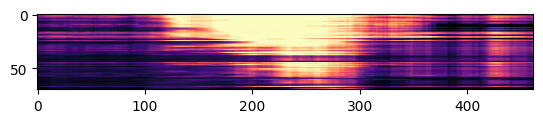

In [ ]:
first_sz_idx_offset = 98
sliced_data = vmat[:,first_sz_idx_offset:]
first_sz_idxs = np.argmax(sliced_data,axis=1)
seized_idxs = np.any(sliced_data,axis=1)
first_sz_idxs += first_sz_idx_offset
sz_times_arr = time_wins[first_sz_idxs[seized_idxs]]
sz_ch_arr = seizure.columns[seized_idxs]
sz_order = np.argsort(sz_times_arr)
to_zero = (sz_times_arr == np.max(sz_times_arr))
viz_sz_probs = sz_probs.copy()
# viz_sz_probs[to_zero,:] = 0
plt.imshow(viz_sz_probs[sz_order,20:-20])
# plt.imshow(vmat[sz_order,:])
plt.clim([0,1])
print(len(sz_ch_arr[~to_zero]))